# **라이브러리 불러오기**

In [ ]:
!pip install catboost

     |████████████████████████████████| 67.3MB 52kB/s 


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#import os
#os.chdir('../open')




In [ ]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
submission=pd.read_csv('sample_submission.csv')

# **[데이터 살펴보기]**

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

In [ ]:
train.describe()

,index,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,credit
count,26457.000000,26457.000000,2.645700e+04,26457.000000,26457.000000,26457.0,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000
mean,13228.000000,0.428658,1.873065e+05,-15958.053899,59068.750728,1.0,0.224742,0.294251,0.091280,2.196848,-26.123294,1.519560
std,7637.622372,0.747326,1.018784e+05,4201.589022,137475.427503,0.0,0.417420,0.455714,0.288013,0.916717,16.559550,0.702283
min,0.000000,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,-60.000000,0.000000
25%,6614.000000,0.000000,1.215000e+05,-19431.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000,-39.000000,1.000000
50%,13228.000000,0.000000,1.575000e+05,-15547.000000,-1539.000000,1.0,0.000000,0.000000,0.000000,2.000000,-24.000000,2.000000
75%,19842.000000,1.000000,2.250000e+05,-12446.000000,-407.000000,1.0,0.000000,1.000000,0.000000,3.000000,-12.000000,2.000000
max,26456.000000,19.000000,1.575000e+06,-7705.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,0.000000,2.000000


In [ ]:
train.describe().columns

Index(['index', 'child_num', 'income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'FLAG_MOBIL', 'work_phone', 'phone', 'email', 'family_size',
       'begin_month', 'credit'],
      dtype='object')

In [ ]:
temp = train['DAYS_BIRTH']//365

In [ ]:
temp.describe()

count    26457.000000
mean       -44.211248
std         11.512586
min        -69.000000
25%        -54.000000
50%        -43.000000
75%        -35.000000
max        -22.000000
Name: DAYS_BIRTH, dtype: float64

In [ ]:
temp2 = train['DAYS_EMPLOYED'] // 365
temp2.describe()

count    26457.000000
mean       161.303247
std        376.583727
min        -44.000000
25%         -9.000000
50%         -5.000000
75%         -2.000000
max       1000.000000
Name: DAYS_EMPLOYED, dtype: float64

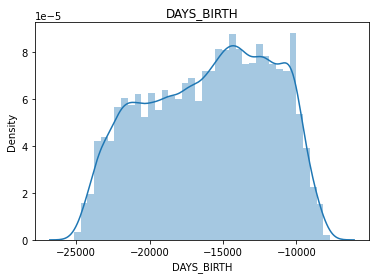

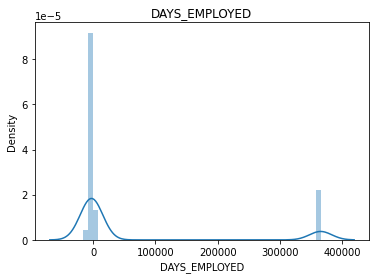

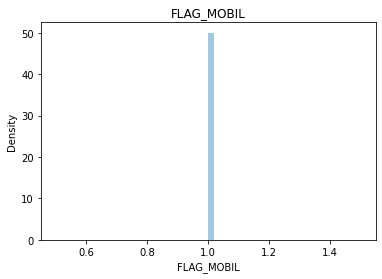

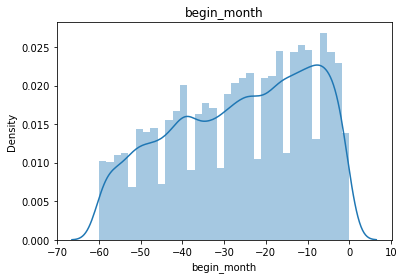

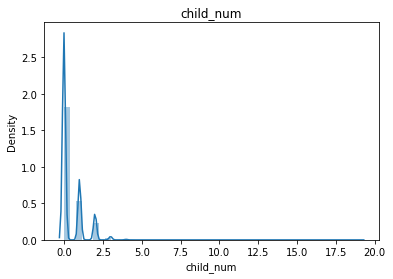

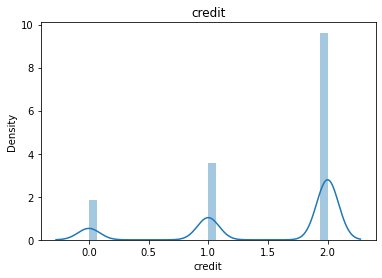

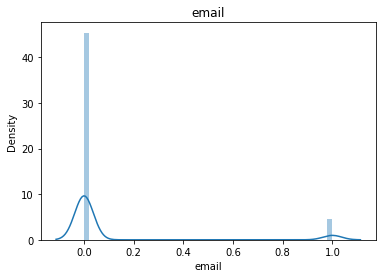

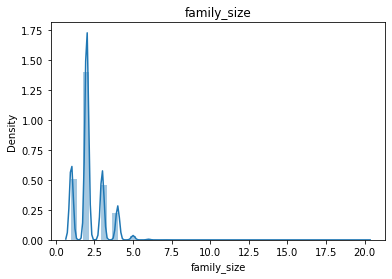

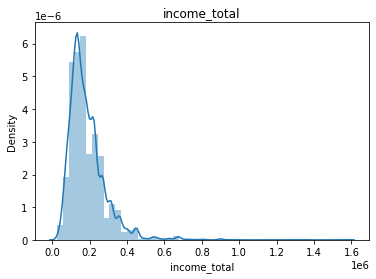

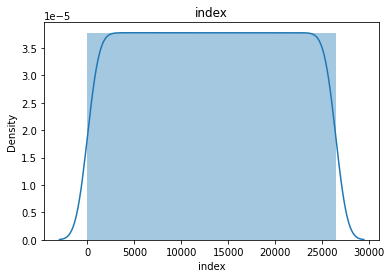

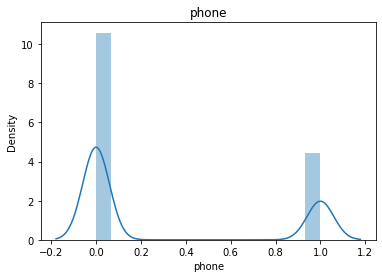

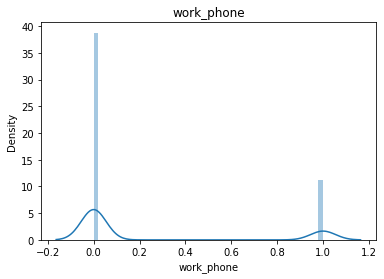

In [ ]:
#단변수 탐색은 seaborn 패키지의 distplot 함수를 이용하면 매우 편합니다.



#우선 이와 같이 전체 변수 중에서 범주형 변수와 기타 인덱스 변수, 종속변수들을 제외하고 수치형 변수만 골라냅니다.

numerical_feature = ['index', 'child_num', 'income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'FLAG_MOBIL', 'work_phone', 'phone', 'email', 'family_size',
       'begin_month', 'credit']

numerical_feature = np.sort(numerical_feature)
#numerical_feature
#변수별로 for문을 돌면서 distplot을 그립니다



for col in numerical_feature:
    sns.distplot(train.loc[train[col].notnull(), col])
    plt.title(col)
    plt.show()


#출처: https://3months.tistory.com/325 [Deep Play]

In [ ]:
temp = train['DAYS_EMPLOYED']
temp.describe()

count     26457.000000
mean      59068.750728
std      137475.427503
min      -15713.000000
25%       -3153.000000
50%       -1539.000000
75%        -407.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [ ]:
temp.isnull().sum()

0

In [ ]:
temp2 = train['email']
temp2.describe()

count    26457.000000
mean         0.091280
std          0.288013
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: email, dtype: float64

In [ ]:
temp2.isnull().sum()

0

In [ ]:
train['phone'].isnull().sum()


0

In [ ]:
train['work_phone'].isnull().sum()

0

## 느낀점
- 1번. 'DAYS_EMPLOYED'
- 음수에서 한 봉오리, 양수에서 한 봉오리 해서 2개가 보임 ? -> 고용중/백수로 1/0으로 구분해보기

--
- 2번. FLAG_MOBIL & email & phone & work_phone
- 핸드폰 소유 여부를 나타내는 categorical 변수이고, 결측치도 없는데 int형 변수로 취급되어 있음 -> categorical 범주형으로 변경해주기


In [ ]:
train.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [ ]:
test.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,26457,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,NaN,2.0,-60.0
1,26458,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,Core staff,2.0,-36.0
2,26459,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,1,0,Laborers,2.0,-40.0
3,26460,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,1,0,0,Drivers,2.0,-41.0
4,26461,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,-17822,-9385,1,1,0,0,Managers,2.0,-8.0


In [ ]:
train.shape

(26457, 20)

In [ ]:
test.shape

(10000, 19)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

## 처리

In [ ]:
train['FLAG_MOBIL'] = train['FLAG_MOBIL'].astype(object)
train['email'] = train['email'].astype(object)
train['phone'] = train['phone'].astype(object)
train['work_phone'] = train['work_phone'].astype(object)

In [ ]:
DAYS_EMPLOYED_copy = list(train['DAYS_EMPLOYED'])

train['DAYS_EMPLOYED'] = [1 if values < 0 else 0 for values in DAYS_EMPLOYED_copy]

In [ ]:
DAYS_EMPLOYED_copy

[-4709,
 -1540,
 -4434,
 -2092,
 -2105,
 -4996,
 -1978,
 -5420,
 -1466,
 -1308,
 -2213,
 -91,
 -2162,
 -2474,
 365243,
 -4056,
 -4553,
 -984,
 365243,
 -6031,
 -1753,
 365243,
 -1357,
 -444,
 365243,
 -3694,
 -3353,
 -3500,
 -2325,
 -1711,
 -227,
 -3452,
 -1628,
 -346,
 -1630,
 -2433,
 -1022,
 -1646,
 -3472,
 -1600,
 -2426,
 -433,
 -554,
 -1876,
 -199,
 -3200,
 365243,
 -3482,
 365243,
 -2010,
 -1101,
 -1101,
 365243,
 -3965,
 -422,
 -3010,
 -9391,
 -642,
 365243,
 365243,
 365243,
 -1371,
 -3153,
 -3337,
 -716,
 -4936,
 -2783,
 -1216,
 -1610,
 -2969,
 -1928,
 -3787,
 -1081,
 365243,
 -219,
 -5500,
 -586,
 -520,
 -231,
 -1672,
 -212,
 -962,
 -1423,
 -1700,
 365243,
 -1215,
 -451,
 -235,
 -5427,
 -4145,
 -9404,
 -2988,
 -691,
 -3629,
 365243,
 365243,
 -2087,
 -1212,
 -588,
 -12332,
 -8491,
 -3046,
 -604,
 -3720,
 -2537,
 -2606,
 -1959,
 -1678,
 -683,
 -2234,
 -164,
 -2371,
 -201,
 -1138,
 -2944,
 365243,
 -2751,
 -674,
 -5756,
 -1854,
 365243,
 -9988,
 -4120,
 -6226,
 -3357,
 -4039,
 -

In [ ]:
train['DAYS_EMPLOYED'].describe()

count    26457.000000
mean         0.832256
std          0.373646
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: DAYS_EMPLOYED, dtype: float64

In [ ]:
# 범주형 변수로 추가 변환
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].astype(object)

## 추가 고민


In [ ]:
train.describe()

,index,child_num,income_total,DAYS_BIRTH,family_size,begin_month,credit
count,26457.000000,26457.000000,2.645700e+04,26457.000000,26457.000000,26457.000000,26457.000000
mean,13228.000000,0.428658,1.873065e+05,-15958.053899,2.196848,-26.123294,1.519560
std,7637.622372,0.747326,1.018784e+05,4201.589022,0.916717,16.559550,0.702283
min,0.000000,0.000000,2.700000e+04,-25152.000000,1.000000,-60.000000,0.000000
25%,6614.000000,0.000000,1.215000e+05,-19431.000000,2.000000,-39.000000,1.000000
50%,13228.000000,0.000000,1.575000e+05,-15547.000000,2.000000,-24.000000,2.000000
75%,19842.000000,1.000000,2.250000e+05,-12446.000000,3.000000,-12.000000,2.000000
max,26456.000000,19.000000,1.575000e+06,-7705.000000,20.000000,0.000000,2.000000


In [ ]:
# begin_month

train['begin_month'].isnull().sum()

0

In [ ]:
# child_num

train['child_num'].isnull().sum()

0

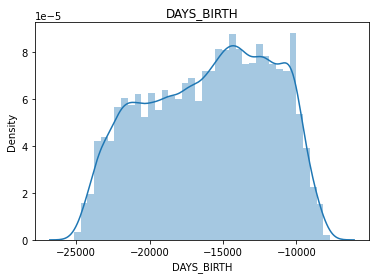

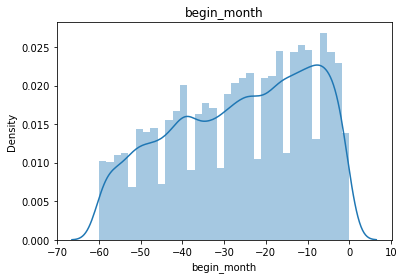

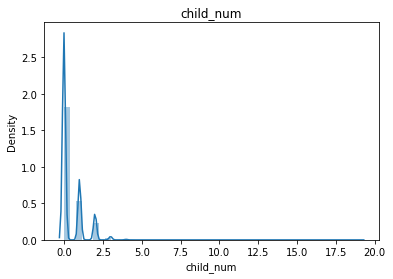

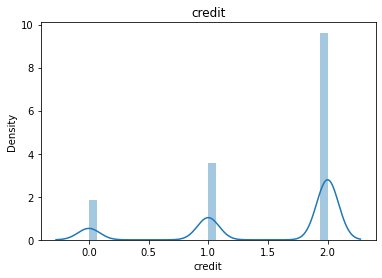

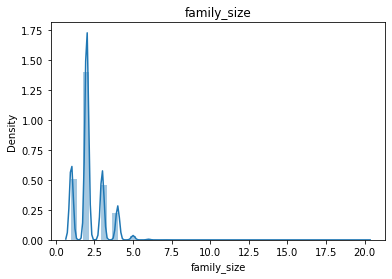

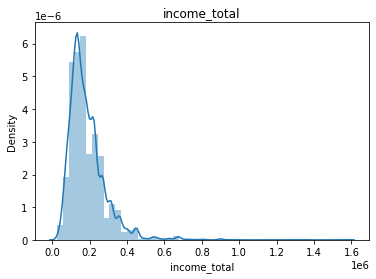

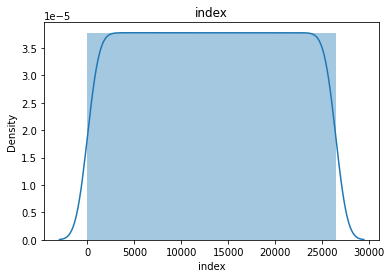

In [ ]:
numerical_feature = ['index',	'child_num',	'income_total',	'DAYS_BIRTH',	'family_size',	'begin_month',	'credit']

numerical_feature = np.sort(numerical_feature)
#numerical_feature
#변수별로 for문을 돌면서 distplot을 그립니다



for col in numerical_feature:
    sns.distplot(train.loc[train[col].notnull(), col])
    plt.title(col)
    plt.show()

## 의문 (추후)

- 'begin_month'와	'credit'의 상관관계 ?
- 'child_num'와 'credit'의 상관관계 ?
- 'income_total'와 'credit'의 상관관계 ?

## 처리 (test 데이터에도 동일한 처리 반복)

In [ ]:
test['FLAG_MOBIL'] = test['FLAG_MOBIL'].astype(object)
test['email'] = test['email'].astype(object)
test['phone'] = test['phone'].astype(object)
test['work_phone'] = test['work_phone'].astype(object)

In [ ]:
DAYS_EMPLOYED_copy2 = list(test['DAYS_EMPLOYED'])

test['DAYS_EMPLOYED'] = [1 if values < 0 else 0 for values in DAYS_EMPLOYED_copy2]

In [ ]:
DAYS_EMPLOYED_copy2

[365243,
 -8671,
 -217,
 -2531,
 -9385,
 -2104,
 -2010,
 365243,
 -4451,
 -3504,
 365243,
 -1028,
 -1064,
 365243,
 365243,
 365243,
 365243,
 365243,
 365243,
 -481,
 -5190,
 -1478,
 -1619,
 -6014,
 -1345,
 -235,
 -1292,
 365243,
 -6276,
 365243,
 -233,
 -2506,
 365243,
 365243,
 -3092,
 -1565,
 -1342,
 365243,
 -1589,
 365243,
 -3447,
 -2602,
 365243,
 -472,
 -5119,
 -2988,
 -127,
 -3596,
 -2967,
 -1194,
 365243,
 365243,
 -2746,
 -1202,
 -316,
 365243,
 -3079,
 -137,
 -1155,
 365243,
 -1921,
 -2321,
 -3303,
 -2078,
 -5006,
 -3718,
 -238,
 -1193,
 365243,
 -3332,
 -1085,
 -652,
 -11494,
 -5107,
 -2967,
 365243,
 365243,
 -2747,
 -1628,
 -2778,
 -3999,
 -596,
 365243,
 365243,
 365243,
 365243,
 -117,
 -338,
 -3900,
 -3243,
 -2849,
 -1458,
 -3017,
 -1610,
 -1616,
 -3900,
 -3337,
 -6237,
 -2696,
 -1430,
 -2417,
 -2177,
 -7280,
 -8172,
 -1682,
 -1846,
 -400,
 -1137,
 -2133,
 365243,
 365243,
 -3778,
 -2593,
 365243,
 -531,
 365243,
 -1175,
 -3541,
 -2451,
 -339,
 -2987,
 365243,
 -3891,

In [ ]:
test['DAYS_EMPLOYED'].describe()

count    10000.000000
mean         0.830300
std          0.375388
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: DAYS_EMPLOYED, dtype: float64

In [ ]:
# 범주형 변수로 추가 변환
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].astype(object)

# **[데이터 전처리]**

In [ ]:
data=pd.concat([train, test], axis=0)
data.shape

(36457, 20)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          36457 non-null  int64  
 1   gender         36457 non-null  object 
 2   car            36457 non-null  object 
 3   reality        36457 non-null  object 
 4   child_num      36457 non-null  int64  
 5   income_total   36457 non-null  float64
 6   income_type    36457 non-null  object 
 7   edu_type       36457 non-null  object 
 8   family_type    36457 non-null  object 
 9   house_type     36457 non-null  object 
 10  DAYS_BIRTH     36457 non-null  int64  
 11  DAYS_EMPLOYED  36457 non-null  object 
 12  FLAG_MOBIL     36457 non-null  object 
 13  work_phone     36457 non-null  object 
 14  phone          36457 non-null  object 
 15  email          36457 non-null  object 
 16  occyp_type     25134 non-null  object 
 17  family_size    36457 non-null  float64
 18  begin_m

## **1. 결측치 제거** 

In [ ]:
data.isnull().sum()

index                0
gender               0
car                  0
reality              0
child_num            0
income_total         0
income_type          0
edu_type             0
family_type          0
house_type           0
DAYS_BIRTH           0
DAYS_EMPLOYED        0
FLAG_MOBIL           0
work_phone           0
phone                0
email                0
occyp_type       11323
family_size          0
begin_month          0
credit           10000
dtype: int64

## 'occyp_type'(직업 유형)이 뭔데 ?

## 범주형 별 credit 파악

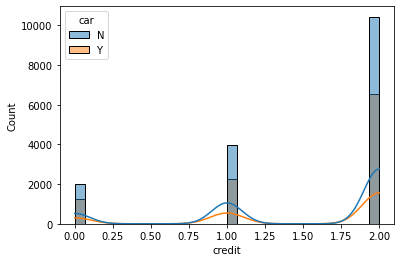

In [ ]:
sns.histplot(x='credit', data=data, hue='car', kde=True)
## 그나마 조금 3 그룹 별 Y/N에 차이 있음(?)

In [ ]:
train['car'].value_counts(normalize=True)*100

N    62.025173
Y    37.974827
Name: car, dtype: float64

In [ ]:
data['car'].value_counts(normalize=True)*100

N    62.02924
Y    37.97076
Name: car, dtype: float64

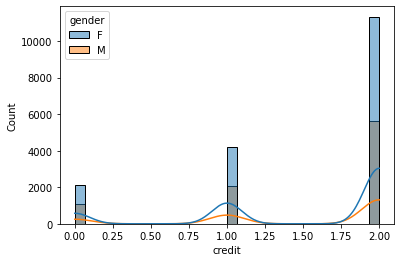

In [ ]:
sns.histplot(x='credit', data=data, hue='gender', kde=True)

## 남/여 성비 차이가 큰 것에 비해 credit에서는 5:5 정도를 보임 (??)

In [ ]:
data['gender'].value_counts(normalize=True)*100

F    67.010451
M    32.989549
Name: gender, dtype: float64

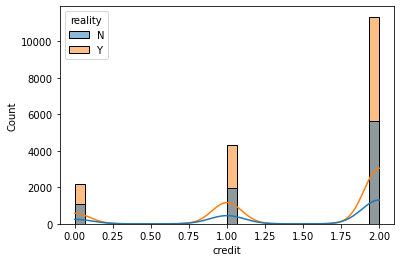

In [ ]:
sns.histplot(x='credit', data=data, hue='reality', kde=True)

## 이것도 구성비 차이가 큰 것에 비해 credit에서는 5:5 정도를 보임 (??)

In [ ]:
data['reality'].value_counts(normalize=True)*100

Y    67.218915
N    32.781085
Name: reality, dtype: float64

In [ ]:
data=data.drop('occyp_type', axis=1)

In [ ]:
data.isnull().sum()

index                0
gender               0
car                  0
reality              0
child_num            0
income_total         0
income_type          0
edu_type             0
family_type          0
house_type           0
DAYS_BIRTH           0
DAYS_EMPLOYED        0
FLAG_MOBIL           0
work_phone           0
phone                0
email                0
family_size          0
begin_month          0
credit           10000
dtype: int64

## 현재 float형인 'family_size'와 'begin_month'를 범주형 그룹별로 나누어보기 (추후)

## **2. Binary variables**

In [ ]:
data['gender'] = data['gender'].replace(['F','M'],[0,1])
print('gender :')
print(data['gender'].value_counts())
print('--------------')

print('Having a car or not : ')
data['car'] = data['car'].replace(['N','Y'],[0,1])
print(data['car'].value_counts())
print('--------------')

print('Having house reality or not: ')
data['reality'] = data['reality'].replace(['N','Y'],[0,1])
print(data['reality'].value_counts())
print('--------------')
      
print('Having a phone or not: ')
print(data['phone'].value_counts())
print('--------------')
      

print('Having a email or not: ')
print(data['email'].value_counts())
print('--------------')
      

print('Having a work phone or not: ')
print(data['work_phone'].value_counts())
print('--------------')

gender :
0    24430
1    12027
Name: gender, dtype: int64
--------------
Having a car or not : 
0    22614
1    13843
Name: car, dtype: int64
--------------
Having house reality or not: 
1    24506
0    11951
Name: reality, dtype: int64
--------------
Having a phone or not: 
0    25709
1    10748
Name: phone, dtype: int64
--------------
Having a email or not: 
0    33186
1     3271
Name: email, dtype: int64
--------------
Having a work phone or not: 
0    28235
1     8222
Name: work_phone, dtype: int64
--------------


## **3. Continuous variable**

### (1) child_num

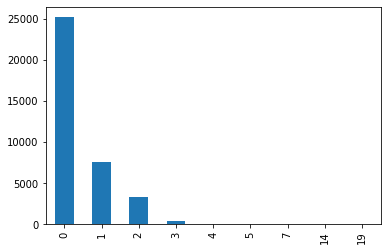

In [ ]:
data['child_num'].value_counts(sort=False).plot.bar()

In [ ]:
data.loc[data['child_num'] >= 2,'child_num']=2

### (2) inc

(2.544, 18.18]      22460
(18.18, 33.66]      11380
(33.66, 49.14]       2099
(49.14, 64.62]        274
(64.62, 80.1]         165
(80.1, 95.58]          58
(95.58, 111.06]         4
(111.06, 126.54]        3
(126.54, 142.02]        6
(142.02, 157.5]         8
Name: income_total, dtype: int64


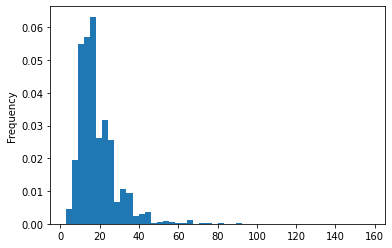

In [ ]:
data['income_total'] = data['income_total'].astype(object)
data['income_total'] = data['income_total']/10000 
print(data['income_total'].value_counts(bins=10,sort=False))
data['income_total'].plot(kind='hist',bins=50,density=True)

In [ ]:
count, bin_dividers =np.histogram(data['income_total'], bins=7)
bin_names=['소득'+str(i) for i in range(7) ]
data['income_total']=pd.cut(x=data['income_total'], bins=bin_dividers, labels=bin_names, include_lowest=True)

### **(3) Type**

In [ ]:
print(data['income_type'].unique())
print(data['edu_type'].unique())
print(data['family_type'].unique())
print(data['house_type'].unique())

['Commercial associate' 'Working' 'State servant' 'Pensioner' 'Student']
['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
['Married' 'Civil marriage' 'Separated' 'Single / not married' 'Widow']
['Municipal apartment' 'House / apartment' 'With parents'
 'Co-op apartment' 'Rented apartment' 'Office apartment']


In [ ]:
from sklearn import preprocessing
label_encoder=preprocessing.LabelEncoder()
data['income_type']=label_encoder.fit_transform(data['income_type'])
data['edu_type']=label_encoder.fit_transform(data['edu_type'])
data['family_type']=label_encoder.fit_transform(data['family_type'])
data['house_type']=label_encoder.fit_transform(data['house_type'])
data['income_total']=label_encoder.fit_transform(data['income_total'])

## **4. Minus continuous variable**

In [ ]:
#minus 변경하고
#구간화 함수
def make_bin(variable, n):
    data[variable]=-data[variable]
    count, bin_dividers =np.histogram(data[variable], bins=n)
    bin_names=[str(i) for i in range(n)]
    data[variable]=pd.cut(x=data[variable], bins=bin_dividers, labels=bin_names, include_lowest=True)
    data[variable]=label_encoder.fit_transform(data[variable])

In [ ]:
data.columns

Index(['index', 'gender', 'car', 'reality', 'child_num', 'income_total',
       'income_type', 'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'work_phone', 'phone', 'email',
       'family_size', 'begin_month', 'credit'],
      dtype='object')

In [ ]:
make_bin('DAYS_BIRTH', n=10)
make_bin('DAYS_EMPLOYED', n=6)
make_bin('begin_month', n=4)

In [ ]:
data

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,credit
0,0,0,0,0,0,0,0,1,1,2,3,0,1,0,0,0,2.0,0,1.0
1,1,0,0,1,1,0,0,4,0,1,2,0,1,0,0,1,3.0,0,1.0
2,2,1,1,1,0,1,4,1,1,1,6,0,1,0,1,0,2.0,1,2.0
3,3,0,0,1,0,0,0,4,1,1,4,0,1,0,1,0,2.0,2,0.0
4,4,0,1,1,0,0,2,1,1,1,4,0,1,0,0,0,2.0,1,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,36452,0,1,1,0,0,4,2,1,1,6,0,1,1,1,0,2.0,1,NaN
9996,36453,1,1,1,0,0,4,4,0,1,1,0,1,1,0,0,2.0,2,NaN
9997,36454,0,0,1,0,1,4,4,1,1,7,0,1,0,0,0,2.0,3,NaN
9998,36455,0,1,0,0,0,0,4,1,1,5,0,1,0,1,0,2.0,2,NaN


# **[데이터 모델링]**

In [ ]:
len(data)

36457

In [ ]:
train=data[:len(data)-10000]
test=data[len(data)-10000:]

In [ ]:
train.shape

(26457, 19)

In [ ]:
test.shape

(10000, 19)

In [ ]:
train_x=train.drop('credit', axis=1)
train_y=train[['credit']]
test_x=test.drop('credit', axis=1)

In [ ]:
print(train_x.shape, train_y.shape, test_x.shape)

(26457, 18) (26457, 1) (10000, 18)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import f1_score
from tensorflow.keras.utils import to_categorical

X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, 
                                                    stratify=train_y, test_size=0.25,
                                                    random_state = 10086)

print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)


clf=RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred=clf.predict_proba(X_val)

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

Train set: 
(19842, 18)
(19842, 1)
Validation set: 
(6615, 18)
(6615, 1)
log_loss: 1.0216846496807834


In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold

def run_kfold(clf):
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test_x.shape[0], 3))  
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        clf.fit(X_train, y_train)
        
        predictions=clf.predict_proba(X_val)
        
        logloss=log_loss(to_categorical(y_val['credit']), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")
        
        sub+=clf.predict_proba(test_x)
        
        
    mean_outcome=np.mean(outcomes)
    
    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

my_submission = run_kfold(clf)

FOLD 0 : logloss:1.0333140740044047
FOLD 1 : logloss:1.0226850625498909
FOLD 2 : logloss:1.095757138167665
FOLD 3 : logloss:1.0225988242866917
FOLD 4 : logloss:1.1030794873676764
Mean:1.0554869172752657


In [ ]:
my_submission

array([[0.106, 0.178, 0.716],
       [0.09 , 0.254, 0.656],
       [0.066, 0.28 , 0.654],
       ...,
       [0.058, 0.126, 0.816],
       [0.112, 0.372, 0.516],
       [0.132, 0.378, 0.49 ]])

In [ ]:
submission

,index,0,1,2
0,26457,0,0,0
1,26458,0,0,0
2,26459,0,0,0
3,26460,0,0,0
4,26461,0,0,0
...,...,...,...,...
9995,36452,0,0,0
9996,36453,0,0,0
9997,36454,0,0,0
9998,36455,0,0,0


In [ ]:
submission.loc[:,1:]=my_submission

In [ ]:
submission

,index,0,1,2
0,26457,0.106,0.178,0.716
1,26458,0.090,0.254,0.656
2,26459,0.066,0.280,0.654
3,26460,0.100,0.198,0.702
4,26461,0.136,0.376,0.488
...,...,...,...,...
9995,36452,0.134,0.322,0.544
9996,36453,0.190,0.350,0.460
9997,36454,0.058,0.126,0.816
9998,36455,0.112,0.372,0.516


In [ ]:
##os.chdir('../baseline')

In [ ]:
submission.to_csv('../baseline_submission.csv', index=False) ## 제출 점수:  0.87911